# Insurance with Regression Model

#### Imported needed modules

In [1]:
from pandas import read_csv, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype


#### Reading information relevant to us from files

In [2]:
training_data = read_csv('files_for_train/train.csv')
test_data = read_csv('files_for_train/test.csv')

#### Data for the train kit

In [3]:
print(training_data.shape)
training_data.head()

(1200000, 21)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


#### Data for the test kit

In [4]:
print(test_data.shape)
test_data.head()

(800000, 20)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


#### Number of columns and names of these columns for both data sets

In [5]:
all_columns = training_data.columns.to_list()
print("Liczba kolumn: ")
print(len(all_columns))
print("Kolumny: ")
for column in all_columns:
    print(column)

Liczba kolumn: 
21
Kolumny: 
id
Age
Gender
Annual Income
Marital Status
Number of Dependents
Education Level
Occupation
Health Score
Location
Policy Type
Previous Claims
Vehicle Age
Credit Score
Insurance Duration
Policy Start Date
Customer Feedback
Smoking Status
Exercise Frequency
Property Type
Premium Amount


In [6]:
all_columns_tests = test_data.columns.to_list()
print("Liczba kolumn: ")
print(len(all_columns_tests))
print("Kolumny: ")
for test_column in all_columns_tests:
    print(test_column)

Liczba kolumn: 
20
Kolumny: 
id
Age
Gender
Annual Income
Marital Status
Number of Dependents
Education Level
Occupation
Health Score
Location
Policy Type
Previous Claims
Vehicle Age
Credit Score
Insurance Duration
Policy Start Date
Customer Feedback
Smoking Status
Exercise Frequency
Property Type


#### Data allocation

In [7]:
all_columns = training_data.iloc[:, :-1]
premium_amounts = training_data.iloc[:, -1]

#### The sum of null data for each column in the case of a test and training kit

In [8]:
training_data.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [9]:
test_data.isnull().sum()

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Policy Start Date            0
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

#### Dividing data into categorical and numerical.

What are these types of data?
 - Numerical data - a type of data that consists of numbers and can be subjected to mathematical operations such as Age, Annual Income etc. 
 - Categorical data - represent sorts of data which can be divided into groups such as Marital Status, Gender etc

In [10]:
numerical_columns = all_columns.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = all_columns.select_dtypes(exclude=[np.number]).columns.tolist()

print(categorical_columns)

['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']


#### Filling categorical data with the word "Missing", and numerical data - average from all data from this type of column

In [11]:
training_data[numerical_columns] = training_data[numerical_columns].fillna(training_data[numerical_columns].mean())
training_data[categorical_columns] = training_data[categorical_columns].fillna("Missing")
test_data[numerical_columns] = test_data[numerical_columns].fillna(test_data[numerical_columns].mean())
test_data[categorical_columns] = test_data[categorical_columns].fillna("Missing")

#### Checking after such cleaning the amount of null data in the columns 

In [12]:
training_data.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

In [13]:
test_data.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
dtype: int64

#### Checking for unique values in each categorical column

In [14]:
training_data['Gender'].unique()


array(['Female', 'Male'], dtype=object)

In [15]:

training_data['Marital Status'].unique()


array(['Married', 'Divorced', 'Single', 'Missing'], dtype=object)

In [16]:

training_data['Education Level'].unique()


array(["Bachelor's", "Master's", 'High School', 'PhD'], dtype=object)

In [17]:

training_data['Occupation'].unique()


array(['Self-Employed', 'Missing', 'Employed', 'Unemployed'], dtype=object)

In [18]:

training_data['Location'].unique()


array(['Urban', 'Rural', 'Suburban'], dtype=object)

In [19]:

training_data['Policy Type'].unique()


array(['Premium', 'Comprehensive', 'Basic'], dtype=object)

In [20]:

training_data['Customer Feedback'].unique()

array(['Poor', 'Average', 'Good', 'Missing'], dtype=object)

In [21]:

training_data['Smoking Status'].unique()


array(['No', 'Yes'], dtype=object)

In [22]:

training_data['Exercise Frequency'].unique()


array(['Weekly', 'Monthly', 'Daily', 'Rarely'], dtype=object)

In [23]:

training_data['Property Type'].unique()

array(['House', 'Apartment', 'Condo'], dtype=object)

Some of the categorical features can be logically expressed as numbers (for example smoking status 1 means yes, 0 means no). Other features like excersices can be turned into frequency scale.

#### Changing part of the categorical values into scale

In [24]:
order = CategoricalDtype(categories=["Poor", "Average", "Good"], ordered=True)

# Zamiana na wartości liczbowe
training_data["Customer Feedback"] = training_data["Customer Feedback"].astype(order)
training_data["Feedback Encoded"] = training_data["Customer Feedback"].cat.codes


In [25]:
order = CategoricalDtype(categories=["No", "Yes"], ordered=True)

# Zamiana na wartości liczbowe
training_data["Smoking Status"] = training_data["Smoking Status"].astype(order)
training_data["Smoking Status Encoded"] = training_data["Smoking Status"].cat.codes

In [26]:
order = CategoricalDtype(categories=["Rarely", "Daily", "Weekely", "Monthly"], ordered=True)

# Zamiana na wartości liczbowe
training_data["Exercise Frequency"] = training_data["Exercise Frequency"].astype(order)
training_data["Exercise Encoded"] = training_data["Exercise Frequency"].cat.codes

#### Correlation matrix

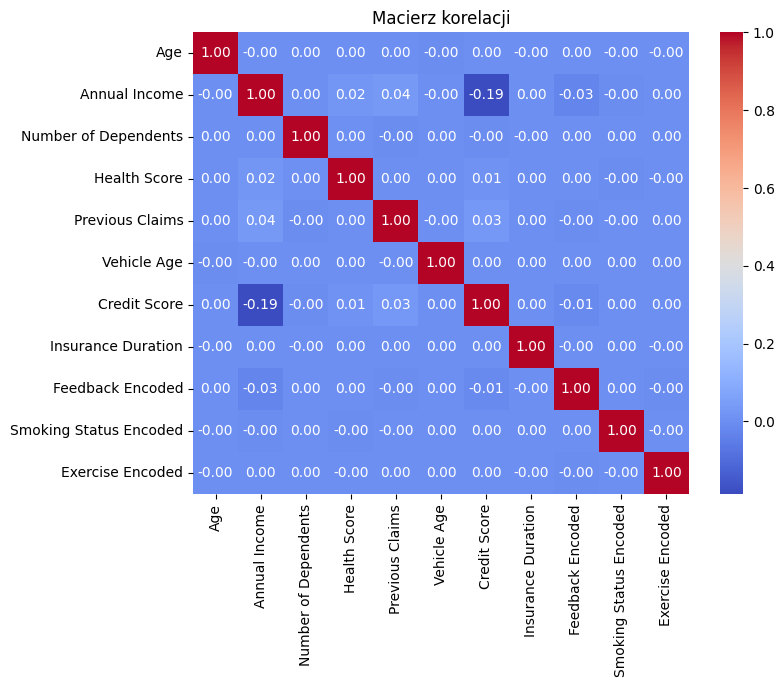

In [27]:
numerical_data = training_data.select_dtypes(include=["number"])

numerical_data = numerical_data.drop(columns=["id"])
numerical_data = numerical_data.drop(columns=["Premium Amount"])

correlation_matrix = numerical_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji")
plt.show()

#### Checking for outliers looking at box plots

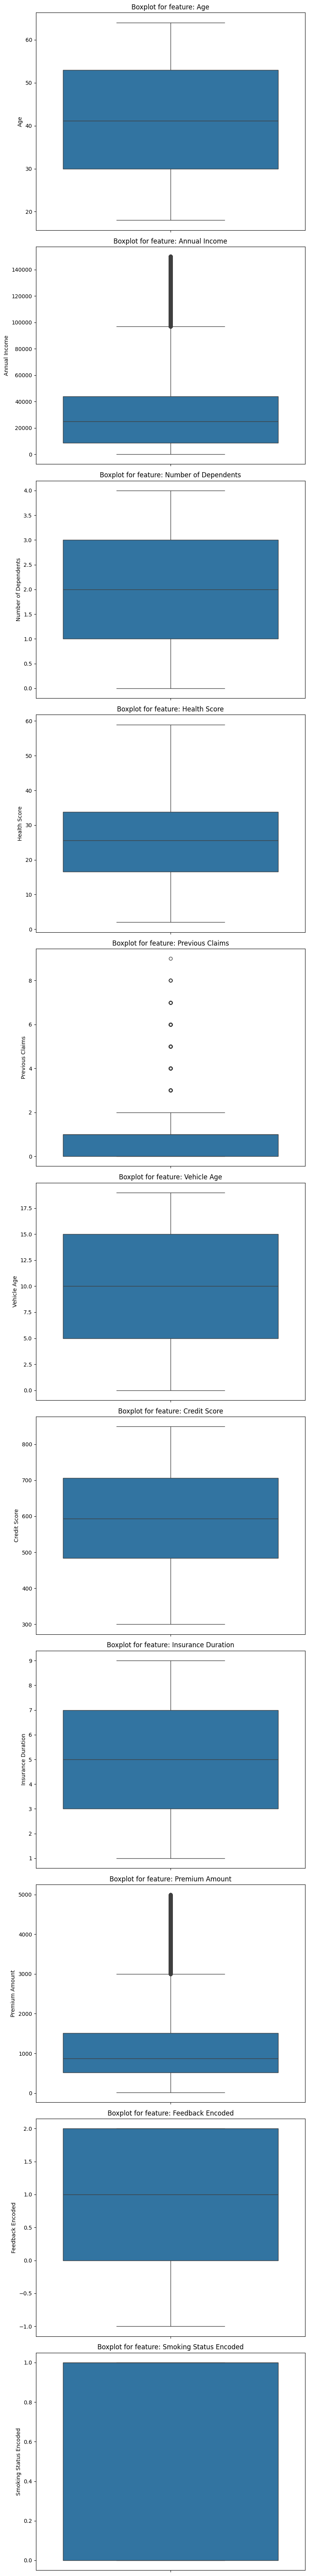

In [28]:

numerical_features = training_data.select_dtypes(include=['number']).columns.to_list()

remaining_numeric_features = numerical_features[1:-1]

fig, axes = plt.subplots(nrows=len(remaining_numeric_features), figsize=(8, 6 * len(remaining_numeric_features)))

for ax, feature in zip(axes, remaining_numeric_features):
        sns.boxplot(y=training_data[feature], ax=ax)
        ax.set_title(f'Boxplot for feature: {feature}')

plt.tight_layout()
plt.show()


#### Checking for outliers looking at box plots for test data

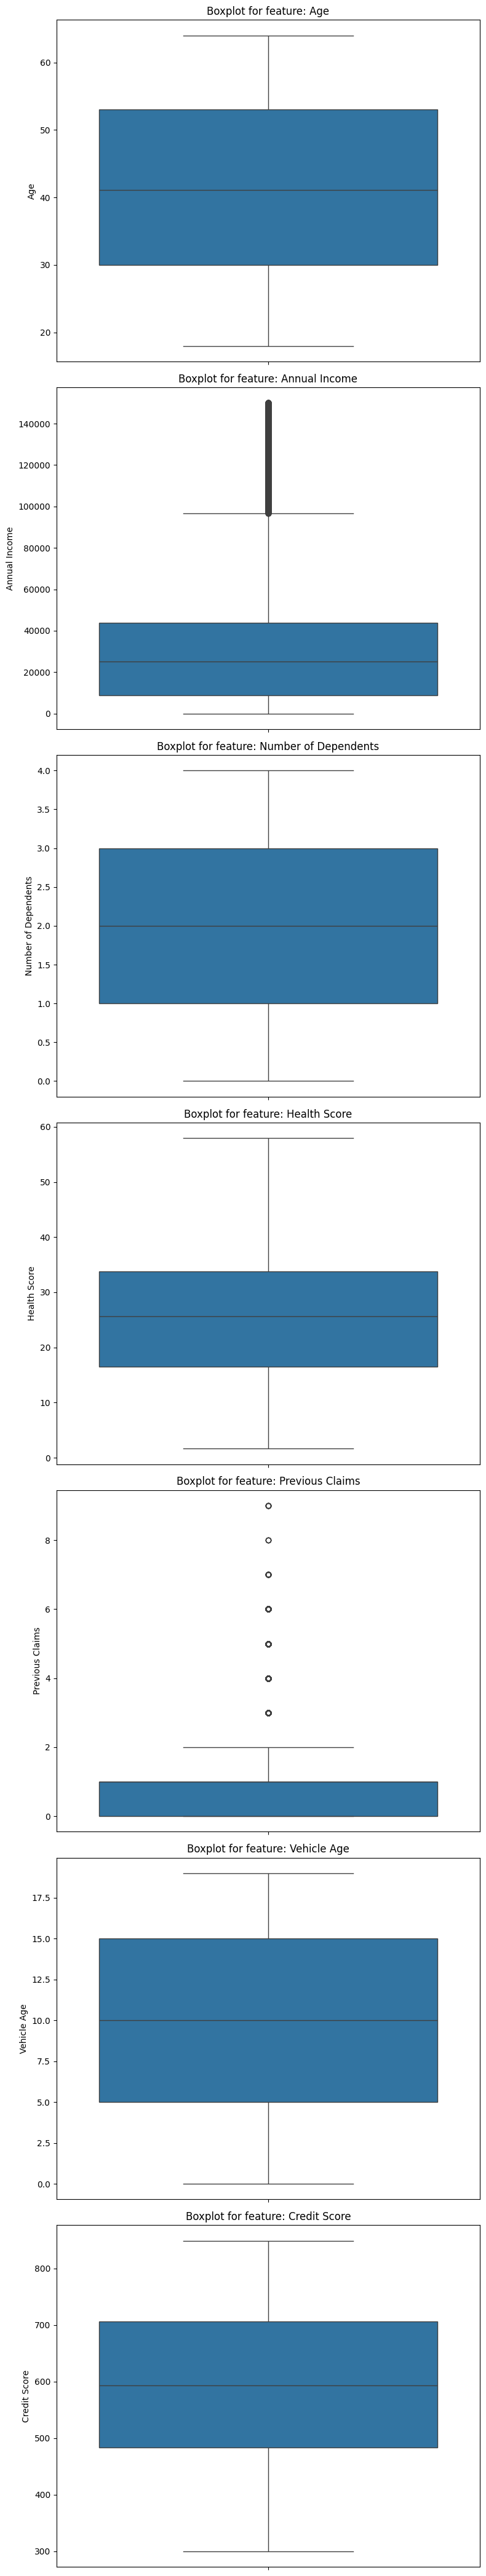

In [29]:
numerical_features = test_data.select_dtypes(include=['number']).columns.to_list()

remaining_numeric_features = numerical_features[1:-1]

fig, axes = plt.subplots(nrows=len(remaining_numeric_features), figsize=(8, 6 * len(remaining_numeric_features)))

for ax, feature in zip(axes, remaining_numeric_features):
        sns.boxplot(y=test_data[feature], ax=ax)
        ax.set_title(f'Boxplot for feature: {feature}')

plt.tight_layout()
plt.show()


Except "previous claims" and "annual income" features have normal distribution. Because those two features mantioned above have assimetrical distribution, we will try IQR method to get rid of outliers.

In [30]:
Q1 = training_data[numerical_columns].quantile(0.25)
Q3 = training_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1


training_data_no_outliers = training_data[~((training_data[numerical_columns] < (Q1 - 1.5 * IQR)) |
                      (training_data[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [31]:
Q1 = test_data[numerical_columns].quantile(0.25)
Q3 = test_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1


test_data_no_outliers = test_data[~((test_data[numerical_columns] < (Q1 - 1.5 * IQR)) |
                      (test_data[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

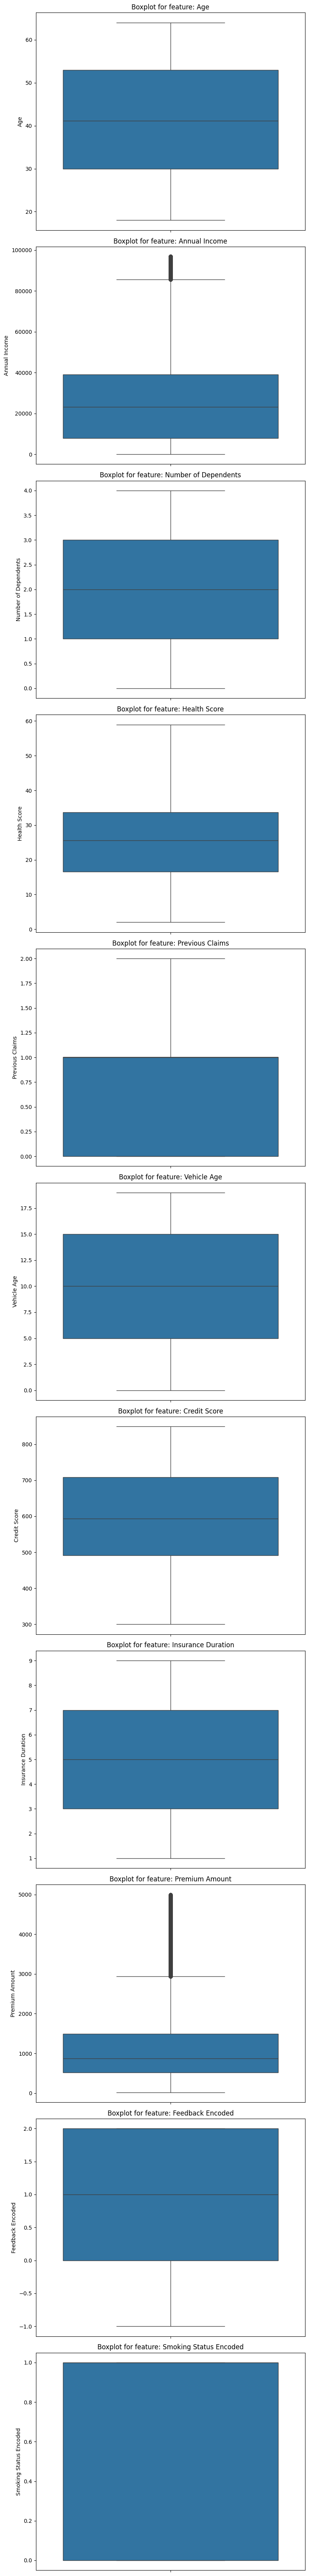

In [32]:
numerical_features = training_data_no_outliers.select_dtypes(include=['number']).columns.to_list()

remaining_numeric_features = numerical_features[1:-1]

fig, axes = plt.subplots(nrows=len(remaining_numeric_features), figsize=(8, 6 * len(remaining_numeric_features)))

for ax, feature in zip(axes, remaining_numeric_features):
        sns.boxplot(y=training_data_no_outliers[feature], ax=ax)
        ax.set_title(f'Boxplot for feature: {feature}')

plt.tight_layout()
plt.show()


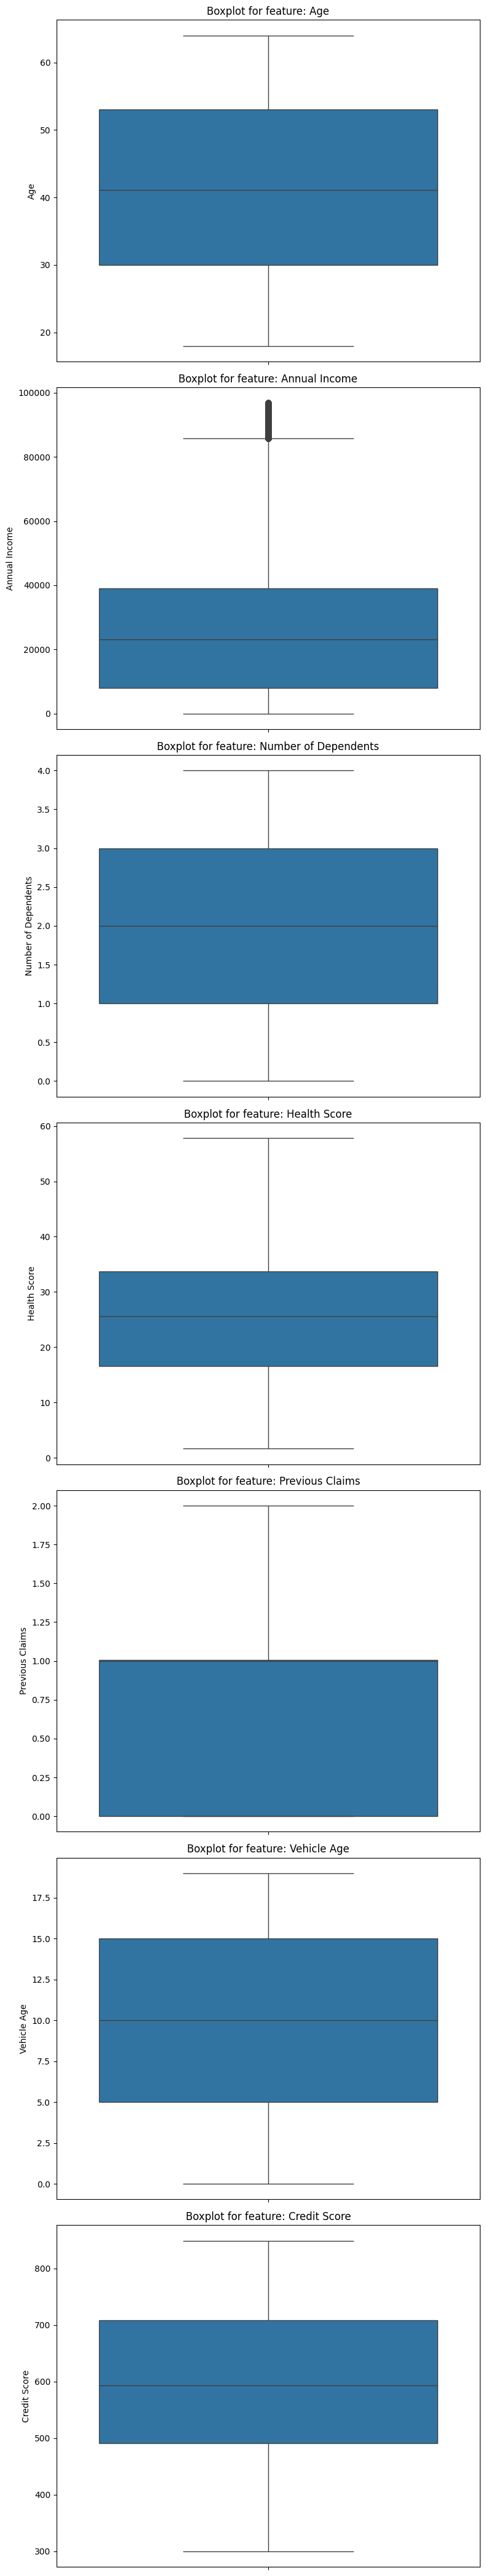

In [33]:
numerical_features = test_data_no_outliers.select_dtypes(include=['number']).columns.to_list()

remaining_numeric_features = numerical_features[1:-1]

fig, axes = plt.subplots(nrows=len(remaining_numeric_features), figsize=(8, 6 * len(remaining_numeric_features)))

for ax, feature in zip(axes, remaining_numeric_features):
        sns.boxplot(y=test_data_no_outliers[feature], ax=ax)
        ax.set_title(f'Boxplot for feature: {feature}')

plt.tight_layout()
plt.show()

#### After removing outlayer and null data, let's split data and give them to XGBRegressor object

In [47]:
for column in categorical_columns:
    training_data[column] = training_data[column].astype('category')


X = training_data.drop('Premium Amount', axis=1)
y = training_data['Premium Amount']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.666666, random_state=0)

#### Let's create XGBRegressor object

In [184]:
xgb_model = XGBRegressor(
    n_estimators=10,
    max_depth=7,
    eta=0.3,
    subsample=0.7,
    enable_categorical=True
    )

Below, xgb_model was matched to the data set, followed by a prediction based on test data

In [185]:
xgb_model.fit(X_train, y_train)
predicted_y = xgb_model.predict(X_test)

We load indexes from the test data file to post them in the results file

In [186]:
dataset_tests = read_csv('files_for_train/test.csv')
ids = dataset_tests['id']

In [187]:
submission = DataFrame()
submission['id'] = ids
submission['Premium Amount'] = predicted_y
submission.to_csv('scores/submit.csv',index=False)

#### Let's see it on a plot

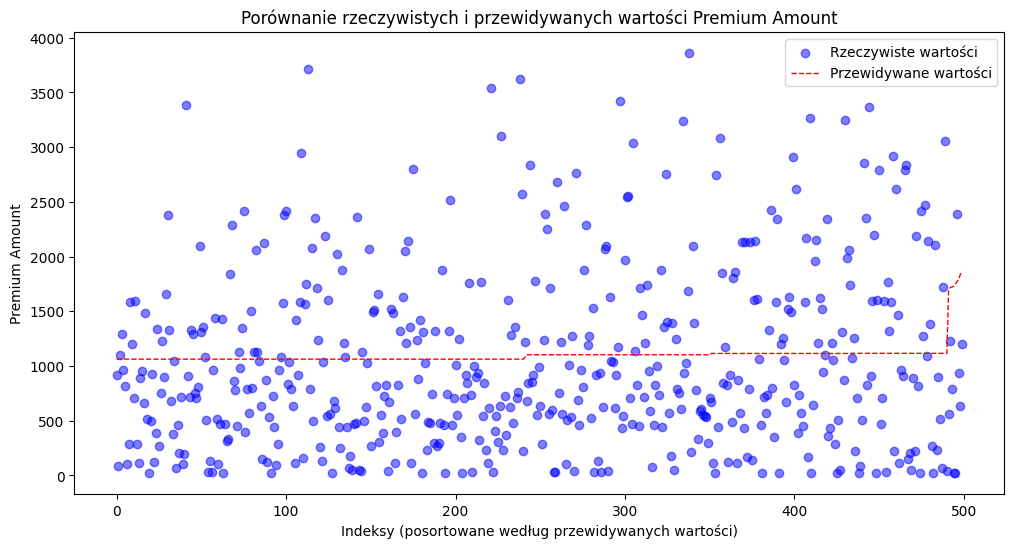

In [188]:
# Wybieramy losową próbkę 500 rekordów
sample_idx = np.random.choice(len(y_test), 500, replace=False)

# Pobieramy wartości rzeczywiste i przewidywane dla wybranych indeksów
y_test_sample = y_test.iloc[sample_idx]
predicted_y_sample = predicted_y[sample_idx]

# Sortujemy próbkę według przewidywanych wartości
sorted_idx = np.argsort(predicted_y_sample)
sample_idx_sorted = sample_idx[sorted_idx]
y_test_sample_sorted = y_test_sample.iloc[sorted_idx]
predicted_y_sample_sorted = predicted_y_sample[sorted_idx]

# Tworzymy wykres
plt.figure(figsize=(12, 6))

# Rzeczywiste wartości (niebieskie kropki)
plt.scatter(range(len(sample_idx_sorted)), y_test_sample_sorted, color='blue', alpha=0.5, label="Rzeczywiste wartości")

# Przewidywane wartości (czerwona linia)
plt.plot(range(len(sample_idx_sorted)), predicted_y_sample_sorted, color='red', linestyle='dashed', linewidth=1, label="Przewidywane wartości")

# Opis wykresu
plt.xlabel("Indeksy (posortowane według przewidywanych wartości)")
plt.ylabel("Premium Amount")
plt.title("Porównanie rzeczywistych i przewidywanych wartości Premium Amount")
plt.legend()

plt.show()


Below, an average error is determined based on the result of the xgb_model model prediction

In [189]:
#   Files, where are scores of xgb_model calculations and reference Premium Amount value

score = read_csv('scores/submit.csv')
sample_submission = read_csv('files_for_train/sample_submission.csv')

error = np.zeros(len(score))

for iterator in range(len(error)):
    error[iterator] = score['Premium Amount'][iterator] - sample_submission['Premium Amount'][iterator]

sum_of_errors = sum(error)

#   Average value of error

average_error = sum_of_errors / len(error)
print(round(average_error, 3))

-0.01
